In [1]:
import pandas as pd
import numpy as np

In [2]:
import pandas as pd
from datetime import datetime
import boto3
from botocore.exceptions import ClientError
from io import StringIO
import re
# from fastparquet import ParquetFile
# import s3fs
# from cleodata.utils.secrets import get_secret
# from cleodata.sources.sync.sync import SyncDataSource
# boto3.setup_default_session(profile_name='DataScientist-878877078763')
# redshift_source = SyncDataSource("data_exploration", use_redshift=True, redshift_cluster="cleo-production-redshift", redshift_db="cleo")

In [3]:
from sagemaker import get_execution_role
role = get_execution_role()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [4]:
def read_from_s3(path):
    """Read parquet files and combine them into a single dataframe"""
    fs = s3fs.core.S3FileSystem()
    all_paths_from_s3 = fs.glob(path=f"{path}*.parquet")

    if len(all_paths_from_s3) > 0:
        s3 = s3fs.S3FileSystem()
        fp_obj = ParquetFile(
            all_paths_from_s3, open_with=s3.open
        )  # use s3fs as the filesystem
        data = fp_obj.to_pandas()
        return data
    elif len(all_paths_from_s3)==1:
        return pd.read_parquet(all_paths_from_s3[0])
    else:
        print(f"Nothing found")
        print(f"paths from a{all_paths_from_s3}")
    
def read_csv_s3(bucket, key):
    try:
        s3 = boto3.client('s3')
        obj = s3.get_object(Bucket=bucket, Key=key)
        df = pd.read_csv(obj['Body'])
        return df
    except ClientError as ex:
        if ex.response['Error']['Code'] == 'NoSuchKey':
            print("Key doesn't match. Please check the key value entered.")


# Create positive and negative data pairs

In [5]:
path_file = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/raw/transactions_2024-05-20_2024-05-20.parquet"

In [6]:
# #df_data_raw = read_from_s3(path_file)
# df_data_raw = pd.read_csv("/Users/claracastellanos/Documents/DATA/MERCHANTS/2024_05_20.csv")
# df_data_raw = pd.read_csv("/Users/claracastellanos/Documents/DATA/MERCHANTS/2024_05_20_sample.csv")

In [7]:
bucket = "cleo-data-science" 
subfolder = "transaction_enrichment/experimental_data/caste/raw/"
conn = boto3.client('s3')
contents = conn.list_objects(Bucket=bucket, Prefix=subfolder)['Contents']
for f in contents:
    print(f['Key'])

transaction_enrichment/experimental_data/caste/raw/
transaction_enrichment/experimental_data/caste/raw/trans_2024-05-10_2024-05-21_240522_14570000_part_00.parquet
transaction_enrichment/experimental_data/caste/raw/trans_2024-05-10_2024-05-21_240522_14570001_part_00.parquet
transaction_enrichment/experimental_data/caste/raw/trans_2024-05-10_2024-05-21_240522_14570002_part_00.parquet
transaction_enrichment/experimental_data/caste/raw/trans_2024-05-10_2024-05-21_240522_14570003_part_00.parquet
transaction_enrichment/experimental_data/caste/raw/trans_2024-05-10_2024-05-21_240522_14570004_part_00.parquet
transaction_enrichment/experimental_data/caste/raw/trans_2024-05-10_2024-05-21_240522_14570005_part_00.parquet
transaction_enrichment/experimental_data/caste/raw/trans_2024-05-10_2024-05-21_240522_14570006_part_00.parquet
transaction_enrichment/experimental_data/caste/raw/trans_2024-05-10_2024-05-21_240522_14570007_part_00.parquet
transaction_enrichment/experimental_data/caste/raw/trans_202

In [8]:
%pip install awswrangler

  Using cached awswrangler-3.7.3-py3-none-any.whl.metadata (17 kB)
Using cached awswrangler-3.7.3-py3-none-any.whl (378 kB)
Note: you may need to restart the kernel to use updated packages.


In [9]:
path_file = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/raw/transactions_2024-05-20_2024-05-20"

In [10]:
import awswrangler as wr
df_data_raw = wr.s3.read_parquet(path=path_file)

In [11]:
df_data_raw.head()

,transaction_id,corrected_made_on,amount,currency_code,description,original_description_plaid,merchant_name,merchant_name_plaid,transaction_type_plaid,counterparty_name,...,category_primary_plaid,payment_channel,payment_method,payment_processor_method,city,region,country,status,decline_code,login_provider_additional_attributes
0,9848927082,2024-05-20,-24.60,USD,GOOGLE *YouTubePremium,,YouTube Premium,,,,...,,,,,,,,declined,not sufficient funds,"{""type"": ""00""}"
1,9848923081,2024-05-20,25.00,USD,ZELLE P2P PAYMENT RECEIVED ON 05/19 \,ZELLE P2P PAYMENT RECEIVED ON 05/19 \\,<NA>,,special,Zelle,...,TRANSFER_IN,other,,,,,,<NA>,,"{""datetime"": null, ""location"": {""lat"": null, ""..."
2,9848926033,2024-05-20,-336.00,USD,CashAdvance / Cash Advance,CashAdvance / Cash Advance,<NA>,,place,,...,LOAN_PAYMENTS,other,,,,,,<NA>,,"{""datetime"": null, ""location"": {""lat"": null, ""..."
3,9848926035,2024-05-20,-7.86,USD,McDonald''s,"Purchase / McDonalds 35052 142-3328095, TN (4633)",McDonald''s,McDonald''s,place,McDonald''s,...,FOOD_AND_DRINK,in store,,,,,,<NA>,,"{""datetime"": null, ""location"": {""lat"": null, ""..."
4,9848926034,2024-05-20,-7.86,USD,McDonald''s,"Purchase / McDonalds 35052 142-3328095, TN (4633)",McDonald''s,McDonald''s,place,McDonald''s,...,FOOD_AND_DRINK,in store,,,,,,<NA>,,"{""datetime"": null, ""location"": {""lat"": null, ""..."


In [12]:
# if original_description_plaid is empty use description
df_data_raw['description_combined'] = df_data_raw['original_description_plaid'].combine_first(df_data_raw['description'])

In [13]:
#replace Nan
# Replace empty spaces, None, and strings with only spaces with NaN
df_data_raw['merchant_name'] = df_data_raw['merchant_name'].replace(r'^\s*$', np.nan, regex=True)
df_data_raw['merchant_name_plaid'] = df_data_raw['merchant_name_plaid'].replace(r'^\s*$', np.nan, regex=True)

In [14]:
#combine merchants
df_data_raw['merchant_name_combined'] = df_data_raw['merchant_name'].combine_first(df_data_raw['merchant_name_plaid'])
# # Combine only when couterparty type is merchant
# mask = df_data_raw['counterparty_type'] == 'merchant'
# # Use np.where to conditionally combine values from df2 into df1
# df_data_raw['merchant_name_combined'] = np.where(mask, df_data_raw['merchant_name_combined'].df_data_raw(df2['counterparty_name']))
df_data_raw['merchant_name_combined']  = df_data_raw['merchant_name_combined'] .combine_first(df_data_raw['counterparty_name'])

In [15]:
df_data_raw[['original_description_plaid','merchant_name_combined','merchant_name','merchant_name_plaid']]

,original_description_plaid,merchant_name_combined,merchant_name,merchant_name_plaid
0,,YouTube Premium,YouTube Premium,<NA>
1,ZELLE P2P PAYMENT RECEIVED ON 05/19 \\,Zelle,<NA>,<NA>
2,CashAdvance / Cash Advance,,<NA>,<NA>
3,"Purchase / McDonalds 35052 142-3328095, TN (4633)",McDonald''s,McDonald''s,McDonald''s
4,"Purchase / McDonalds 35052 142-3328095, TN (4633)",McDonald''s,McDonald''s,McDonald''s
...,...,...,...,...
6492889,FanDuel,FanDuel,FanDuel,FanDuel
6492890,FanDuel,FanDuel,FanDuel,FanDuel
6492891,FanDuel,FanDuel,FanDuel,FanDuel
6492892,FanDuel,FanDuel,FanDuel,FanDuel


In [16]:
#replace 'other' with ''
df_data_raw['payment_channel_processed'] = df_data_raw['payment_channel'].apply(lambda x: 'None' if x == 'other' else x)

In [17]:
df_data_raw['len_description'] = df_data_raw['original_description_plaid'].apply(lambda x: len(x))
df_data_raw = df_data_raw[df_data_raw['len_description'] >2]
df_data_raw.reset_index(drop=True, inplace=True)

In [18]:
df_data_raw['original_description_plaid_processed'] =  df_data_raw['original_description_plaid'].apply(lambda x: re.sub('\\\\+','\\\\',x))
df_data_raw['original_description_plaid_processed'] =  df_data_raw['original_description_plaid_processed'].apply(lambda x: re.sub(r'\d{4,}', ' ', x))

# #if there are 4 or more integers replace with a space
# output_string = re.sub(r'\d{4,}', ' ', df_data_raw['sentence'][1000050])
df_data_raw['original_description_plaid_processed'] =  df_data_raw['original_description_plaid_processed'].apply(lambda x: re.sub(' +',' ',x))



In [19]:
df_data_raw['str_amount'] = df_data_raw['amount'].apply(lambda x: str(x))
df_data_raw['sentence'] = df_data_raw['original_description_plaid_processed'] + ' Channel: ' + df_data_raw['payment_channel_processed'] + '. Amount: ' + df_data_raw['str_amount']
df_data_raw['sentence2'] = df_data_raw['original_description_plaid_processed'] +' Type: ' +df_data_raw['counterparty_type']+'. Channel: ' + df_data_raw['payment_channel_processed'] + '. Amount: ' + df_data_raw['str_amount']
try:
    df_data_raw.drop('str_amount', axis=1, inplace=True)
except:
    pass

In [20]:
#if there are more than 4 numbers in a row in a word replace it with a ' '

In [21]:
df_data_raw['len_sentence'] = df_data_raw['sentence'].apply(lambda x: len(x))
df_data_raw['num_words'] = df_data_raw['sentence'].apply(lambda x: len(x.split(' ')))

In [22]:
print(df_data_raw['sentence'][1000050])

PURCHASE AUTHORIZED ON 05/19 SQ *RUBY''S MEXICAN Tyler TX S CARD  Channel: in store. Amount: -4.33


In [23]:
df_data_raw['sentence'][0]

'ZELLE P2P PAYMENT RECEIVED ON 05/19 \\ Channel: None. Amount: 25.00'

In [24]:
df_data_raw['num_words'].describe()

count    6.466409e+06
mean     1.121393e+01
std      3.703330e+00
min      5.000000e+00
25%      8.000000e+00
50%      1.100000e+01
75%      1.400000e+01
max      4.800000e+01
Name: num_words, dtype: float64

In [25]:
df_data_raw['num_words'].max()*3

144

In [26]:
df_data_raw['len_sentence'].describe()

count    6.466409e+06
mean     7.202736e+01
std      2.138463e+01
min      2.900000e+01
25%      5.500000e+01
50%      6.900000e+01
75%      8.800000e+01
max      2.990000e+02
Name: len_sentence, dtype: float64

In [27]:
df_data_raw['len_sentence'].max()

299

In [28]:
print(df_data_raw[df_data_raw['len_sentence']==df_data_raw['len_sentence'].max()]['description'])

1595652    FEDWIRE CREDIT VIA: BANK OF AMERICA, N.A./0260...
Name: description, dtype: string


In [29]:
df_data_raw.loc[1595652, 'original_description_plaid_processed']

'FEDWIRE CREDIT VIA: BANK OF AMERICA, N.A./ B/O: OMAR HOSSAM ELDIN ELFEKY DXB DUBAI UAE REF: CHASE NYC/CTR/BNF=OMAR H ELFEKY THE WOODLANDS TX - US/AC- RFB=EPHCOR QL5VA OBI=K BBI=/OCMT/AED ,75/EXCH/3,679/AC C/ OMAR ELFEKY 700 SW 108T H AVE APT 304 IMAD: B6B7HU1R TRN: FF'

In [30]:
df_data_raw['counterparty_type'].value_counts()

counterparty_type
merchant                 3356628
financial_institution    1181450
                         1136043
payment_app               710335
marketplace                75972
income_source               4178
payment_terminal            1803
Name: count, dtype: Int64

In [31]:
print(df_data_raw.loc[2820998])

transaction_id                                                                 9860635976
corrected_made_on                                                              2024-05-20
amount                                                                            1300.00
currency_code                                                                         USD
description                             FEDWIRE CREDIT VIA: WELLS FARGO BANK, N.A./121...
original_description_plaid              FEDWIRE CREDIT VIA: WELLS FARGO BANK, N.A./121...
merchant_name                                                                        <NA>
merchant_name_plaid                                                                  <NA>
transaction_type_plaid                                                            special
counterparty_name                                                              Chase Bank
counterparty_type                                                   financial_institution
counterpar

In [32]:
df_data_raw[df_data_raw['merchant_name_combined']=='']

,transaction_id,corrected_made_on,amount,currency_code,description,original_description_plaid,merchant_name,merchant_name_plaid,transaction_type_plaid,counterparty_name,...,login_provider_additional_attributes,description_combined,merchant_name_combined,payment_channel_processed,len_description,original_description_plaid_processed,sentence,sentence2,len_sentence,num_words
1,9848926033,2024-05-20,-336.00,USD,CashAdvance / Cash Advance,CashAdvance / Cash Advance,<NA>,<NA>,place,,...,"{""datetime"": null, ""location"": {""lat"": null, ""...",CashAdvance / Cash Advance,,None,26,CashAdvance / Cash Advance,CashAdvance / Cash Advance Channel: None. Amou...,CashAdvance / Cash Advance Type: . Channel: No...,57,8
4,9848932218,2024-05-20,75.00,USD,CREDIT,CREDIT,<NA>,<NA>,special,,...,"{""datetime"": null, ""location"": {""lat"": null, ""...",CREDIT,,None,6,CREDIT,CREDIT Channel: None. Amount: 75.00,CREDIT Type: . Channel: None. Amount: 75.00,35,5
5,9848944528,2024-05-20,25.00,USD,Mobile Banking Transfer Deposit 05/18 0056,Mobile Banking Transfer Deposit 05/18 0056,<NA>,<NA>,special,,...,"{""datetime"": ""2024-05-20T00:00:00.000Z"", ""loca...",Mobile Banking Transfer Deposit 05/18 0056,,None,42,Mobile Banking Transfer Deposit 05/18,Mobile Banking Transfer Deposit 05/18 Channel...,Mobile Banking Transfer Deposit 05/18 Type: ....,67,10
6,9848944529,2024-05-20,-25.00,USD,Mobile Banking Transfer Withdrawal 05/18 0901,Mobile Banking Transfer Withdrawal 05/18 0901,<NA>,<NA>,special,,...,"{""datetime"": ""2024-05-20T00:00:00.000Z"", ""loca...",Mobile Banking Transfer Withdrawal 05/18 0901,,None,45,Mobile Banking Transfer Withdrawal 05/18,Mobile Banking Transfer Withdrawal 05/18 Chan...,Mobile Banking Transfer Withdrawal 05/18 Type...,71,10
8,9848948202,2024-05-20,-55.00,USD,Internet Transfer to x9757 CK -,Internet Transfer to x9757 CK -,<NA>,<NA>,special,,...,"{""datetime"": null, ""location"": {""lat"": null, ""...",Internet Transfer to x9757 CK -,,None,33,Internet Transfer to x CK -,Internet Transfer to x CK - Channel: None. Am...,Internet Transfer to x CK - Type: . Channel: ...,58,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6466351,9869982573,2024-05-20,-0.02,USD,SAVING0520 084106767026744 Brigh,SAVING0520 084106767026744 Brigh,<NA>,<NA>,place,,...,"{""datetime"": null, ""location"": {""lat"": null, ""...",SAVING0520 084106767026744 Brigh,,online,32,SAVING Brigh,SAVING Brigh Channel: online. Amount: -0.02,SAVING Brigh Type: . Channel: online. Amount: ...,43,6
6466352,9869982572,2024-05-20,-0.01,USD,SAVING0520 084106767026685 Brigh,SAVING0520 084106767026685 Brigh,<NA>,<NA>,place,,...,"{""datetime"": null, ""location"": {""lat"": null, ""...",SAVING0520 084106767026685 Brigh,,online,32,SAVING Brigh,SAVING Brigh Channel: online. Amount: -0.01,SAVING Brigh Type: . Channel: online. Amount: ...,43,6
6466353,9869982571,2024-05-20,-0.09,USD,SAVING0520 084106767026649 Brigh,SAVING0520 084106767026649 Brigh,<NA>,<NA>,place,,...,"{""datetime"": null, ""location"": {""lat"": null, ""...",SAVING0520 084106767026649 Brigh,,online,32,SAVING Brigh,SAVING Brigh Channel: online. Amount: -0.09,SAVING Brigh Type: . Channel: online. Amount: ...,43,6
6466354,9869982570,2024-05-20,-0.01,USD,SAVING0520 084106767026616 Brigh,SAVING0520 084106767026616 Brigh,<NA>,<NA>,place,,...,"{""datetime"": null, ""location"": {""lat"": null, ""...",SAVING0520 084106767026616 Brigh,,online,32,SAVING Brigh,SAVING Brigh Channel: online. Amount: -0.01,SAVING Brigh Type: . Channel: online. Amount: ...,43,6


In [33]:
df_data_raw['merchant_name_combined'].value_counts()[0:30]

merchant_name_combined
                           641466
Cash App                   281588
Zelle                      171193
Savings                    163412
Apple                      122966
Walmart                    118786
Earnin                     108522
Cleo                        98269
McDonald''s                 97266
Round Up                    95844
Amazon                      91197
Cash Withdrawal             78822
Online Banking Transfer     76885
Apple Cash                  73241
MoneyLion                   68691
Uber                        64315
Dave Inc                    59840
Venmo                       57728
Brigit                      57255
Empower                     53746
Paypal                      52426
Albert                      47801
Fan Duel Sportsbook         45824
Shell                       44952
Builder                     44844
Afterpay                    44620
7 Eleven                    43226
Dollar General              42537
Circle K                 

In [34]:
# create pairs based on merchant_name_combined
unique_merchants = df_data_raw['merchant_name_combined'].unique()
print(unique_merchants)
print(len(unique_merchants))

<StringArray>
[                         'Zelle',                               '',
                    "McDonald''s",                       'Cash App',
                        'Q Nails',                        'Savings',
                       'Afterpay',                   'Ruby Tuesday',
                         'Klarna',                'Laundry Service',
 ...
            'Fresco Communitylos',           'Lakespancakehousellc',
           "Barnaby's Family Inn",     'Hair Style Express Chicago',
               'Ben Watts Marina',  'Tender Care Veterinary Falcon',
                  'Wangechiurban',             'Uncle Henry S Deli',
                     'Anju House', "Frank 'N Hank's Ba Los Angeles"]
Length: 358891, dtype: string
358891


In [35]:
df_data_raw['merchant_name_combined_len'] = df_data_raw['merchant_name_combined'].apply(lambda x: len(x))

In [36]:
df_data = df_data_raw[df_data_raw['merchant_name_combined_len']>1]

In [37]:
df_data[df_data['merchant_name_combined'].isnull()]

,transaction_id,corrected_made_on,amount,currency_code,description,original_description_plaid,merchant_name,merchant_name_plaid,transaction_type_plaid,counterparty_name,...,description_combined,merchant_name_combined,payment_channel_processed,len_description,original_description_plaid_processed,sentence,sentence2,len_sentence,num_words,merchant_name_combined_len


In [38]:
df_data.reset_index(drop=False)

,index,transaction_id,corrected_made_on,amount,currency_code,description,original_description_plaid,merchant_name,merchant_name_plaid,transaction_type_plaid,...,description_combined,merchant_name_combined,payment_channel_processed,len_description,original_description_plaid_processed,sentence,sentence2,len_sentence,num_words,merchant_name_combined_len
0,0,9848923081,2024-05-20,25.00,USD,ZELLE P2P PAYMENT RECEIVED ON 05/19 \,ZELLE P2P PAYMENT RECEIVED ON 05/19 \\,<NA>,<NA>,special,...,ZELLE P2P PAYMENT RECEIVED ON 05/19 \\,Zelle,None,41,ZELLE P2P PAYMENT RECEIVED ON 05/19 \,ZELLE P2P PAYMENT RECEIVED ON 05/19 \ Channel:...,ZELLE P2P PAYMENT RECEIVED ON 05/19 \ Type: pa...,66,11,5
1,2,9848926035,2024-05-20,-7.86,USD,McDonald''s,"Purchase / McDonalds 35052 142-3328095, TN (4633)",McDonald''s,McDonald''s,place,...,"Purchase / McDonalds 35052 142-3328095, TN (4633)",McDonald''s,in store,49,"Purchase / McDonalds 142- , TN ( )","Purchase / McDonalds 142- , TN ( ) Channel: in...","Purchase / McDonalds 142- , TN ( ) Type: merch...",67,13,11
2,3,9848926034,2024-05-20,-7.86,USD,McDonald''s,"Purchase / McDonalds 35052 142-3328095, TN (4633)",McDonald''s,McDonald''s,place,...,"Purchase / McDonalds 35052 142-3328095, TN (4633)",McDonald''s,in store,49,"Purchase / McDonalds 142- , TN ( )","Purchase / McDonalds 142- , TN ( ) Channel: in...","Purchase / McDonalds 142- , TN ( ) Type: merch...",67,13,11
3,7,9848945525,2024-05-20,19.65,USD,Transfer from Cash App,Transfer from Cash App,Cash App,<NA>,special,...,Transfer from Cash App,Cash App,None,22,Transfer from Cash App,Transfer from Cash App Channel: None. Amount: ...,Transfer from Cash App Type: payment_app. Chan...,51,8,8
4,11,9848948208,2024-05-20,-100.00,USD,POS Withdrawal (FIS) Q NAILS Q NAILS NEWPORT T...,POS Withdrawal (FIS) Q NAILS Q NAILS NEWPORT T...,Q Nails,Q Nails,place,...,POS Withdrawal (FIS) Q NAILS Q NAILS NEWPORT T...,Q Nails,in store,53,POS Withdrawal (FIS) Q NAILS Q NAILS NEWPORT T...,POS Withdrawal (FIS) Q NAILS Q NAILS NEWPORT T...,POS Withdrawal (FIS) Q NAILS Q NAILS NEWPORT T...,85,15,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5824100,6466404,9857334046,2024-05-20,-15.00,USD,FanDuel,FanDuel,FanDuel,FanDuel,place,...,FanDuel,FanDuel,in store,7,FanDuel,FanDuel Channel: in store. Amount: -15.00,FanDuel Type: merchant. Channel: in store. Amo...,41,6,7
5824101,6466405,9857334047,2024-05-20,-25.00,USD,FanDuel,FanDuel,FanDuel,FanDuel,place,...,FanDuel,FanDuel,in store,7,FanDuel,FanDuel Channel: in store. Amount: -25.00,FanDuel Type: merchant. Channel: in store. Amo...,41,6,7
5824102,6466406,9857334048,2024-05-20,-25.00,USD,FanDuel,FanDuel,FanDuel,FanDuel,place,...,FanDuel,FanDuel,in store,7,FanDuel,FanDuel Channel: in store. Amount: -25.00,FanDuel Type: merchant. Channel: in store. Amo...,41,6,7
5824103,6466407,9857334049,2024-05-20,-25.00,USD,FanDuel,FanDuel,FanDuel,FanDuel,place,...,FanDuel,FanDuel,in store,7,FanDuel,FanDuel Channel: in store. Amount: -25.00,FanDuel Type: merchant. Channel: in store. Amo...,41,6,7


In [39]:
df_merchant_volume = df_data['merchant_name_combined'].value_counts(dropna=False).to_frame()
df_merchant_volume

,count
merchant_name_combined,
Cash App,281588
Zelle,171193
Savings,163412
Apple,122966
Walmart,118786
...,...
Sp Dossier Perfumes,1
Georgia Chocolate Fac,1
Macipalle Paris,1


In [40]:
n_tot_trans  = df_data.shape[0]
df_merchant_volume['perc_traffic'] = df_merchant_volume['count']/n_tot_trans
df_merchant_volume.sort_values(by='perc_traffic', ascending=False)
df_merchant_volume['cumulative_traffic'] = df_merchant_volume['perc_traffic'].cumsum()
df_merchant_volume

,count,perc_traffic,cumulative_traffic
merchant_name_combined,,,
Cash App,281588,0.048349,0.048349
Zelle,171193,0.029394,0.077743
Savings,163412,0.028058,0.1058
Apple,122966,0.021113,0.126914
Walmart,118786,0.020396,0.147309
...,...,...,...
Sp Dossier Perfumes,1,0.0,0.999999
Georgia Chocolate Fac,1,0.0,0.999999
Macipalle Paris,1,0.0,1.0


In [41]:
df_merchant_volume[0:1000]

,count,perc_traffic,cumulative_traffic
merchant_name_combined,,,
Cash App,281588,0.048349,0.048349
Zelle,171193,0.029394,0.077743
Savings,163412,0.028058,0.1058
Apple,122966,0.021113,0.126914
Walmart,118786,0.020396,0.147309
...,...,...,...
Clipper Systems Mobile,261,0.000045,0.806906
Taild Sports Inc,260,0.000045,0.806951
Twin Spires,259,0.000044,0.806995


(0.0, 4000.0)

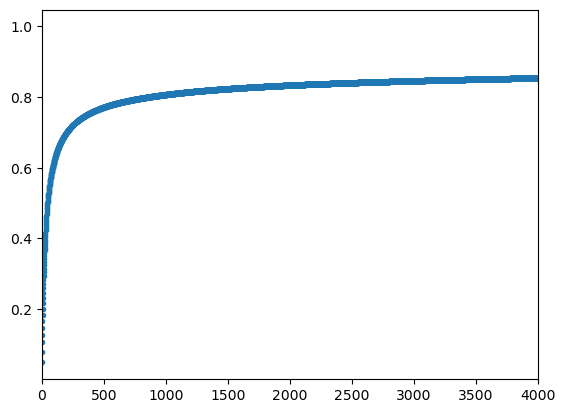

In [42]:
import matplotlib.pyplot as plt
plt.plot(np.arange(df_merchant_volume.shape[0]),df_merchant_volume['cumulative_traffic'],'.')
plt.xlim([0,4000])

In [43]:
df_merchant_volume.reset_index(drop=False,inplace=True)
df_merchant_volume

,merchant_name_combined,count,perc_traffic,cumulative_traffic
0,Cash App,281588,0.048349,0.048349
1,Zelle,171193,0.029394,0.077743
2,Savings,163412,0.028058,0.1058
3,Apple,122966,0.021113,0.126914
4,Walmart,118786,0.020396,0.147309
...,...,...,...,...
358870,Sp Dossier Perfumes,1,0.0,0.999999
358871,Georgia Chocolate Fac,1,0.0,0.999999
358872,Macipalle Paris,1,0.0,1.0
358873,Ihatov,1,0.0,1.0


In [68]:
merchants_top_n = df_merchant_volume['merchant_name_combined'][0:5000].tolist()
print(len(merchants_top_n))
merchants_top_n

5000


['Cash App',
 'Zelle',
 'Savings',
 'Apple',
 'Walmart',
 'Earnin',
 'Cleo',
 "McDonald''s",
 'Round Up',
 'Amazon',
 'Cash Withdrawal',
 'Online Banking Transfer',
 'Apple Cash',
 'MoneyLion',
 'Uber',
 'Dave Inc',
 'Venmo',
 'Brigit',
 'Empower',
 'Paypal',
 'Albert',
 'Fan Duel Sportsbook',
 'Shell',
 'Builder',
 'Afterpay',
 '7 Eleven',
 'Dollar General',
 'Circle K',
 'USAA',
 'Uber Eats',
 'Klover',
 'Amazon Prime',
 'Zip In',
 'Target',
 'Starbucks',
 'Draftkings',
 'Lyft',
 'Doordash',
 'Klarna',
 'Sezzle',
 'Overdraft Charge',
 "Dunkin'' Donuts",
 'Chick-fil-A',
 'Taco Bell',
 'Affirm',
 '365 Markets',
 'FloatMe',
 'Speedway',
 "Wendy''s",
 'Dollar Tree',
 'QuikTrip',
 'Chevron',
 'Kroger',
 'Walgreens',
 'ATM Fee',
 'BP',
 'Wells Fargo',
 'Family Dollar',
 'Burger King',
 'Save Your Change',
 'Wawa',
 'Publix',
 'Capital One',
 'CVS Pharmacy',
 'FanDuel',
 'Bank of America ATM',
 'Netflix',
 'Sonic',
 'BetMGM.com',
 'Sunoco',
 'Sheetz',
 'T-Mobile',
 'Instacart',
 'Wallet',
 

In [55]:
20*50/3600

0.2777777777777778

In [56]:
166/60

2.7666666666666666

In [67]:
18*60*10*5/3600

15.0

In [58]:
# !pwd
# !ls -ltr /opt/amazon/sagemaker/sagemaker-code-editor-server-data/data/User/History
# !more /opt/amazon/sagemaker/sagemaker-code-editor-server-data/data/User/History/14a6abb3/entries.json
# !touch /opt/amazon/sagemaker/sagemaker-code-editor-server-data/data/User/History/
# !touch /home/sagemaker-user/toto
# !echo "abdc" > /home/sagemaker-user/toto
# !more /home/sagemaker-user/toto

In [63]:
pip install path

Note: you may need to restart the kernel to use updated packages.


In [69]:
from path import Path

In [70]:
#This step needs to be parallelized
n_pairs = 5000
df_all = pd.DataFrame()
for i,merchant in enumerate(merchants_top_n):
  print(i,merchant)
  df_s1 = df_data_raw[df_data_raw['merchant_name_combined']==merchant][['transaction_id','sentence','sentence2','merchant_name_combined']]
  df_s2 = df_data_raw[df_data_raw['merchant_name_combined']!=merchant][['transaction_id','merchant_name_combined']]
  df_negative = pd.concat([df_s1.sample(min(df_s1.shape[0],2*n_pairs),random_state=1)[['transaction_id','sentence','sentence2']].reset_index(drop=True), \
                           df_s2.sample(min(df_s1.shape[0],2*n_pairs), random_state=1)[['merchant_name_combined']].reset_index(drop=True)], axis=1 , ignore_index=True)
  df_negative['true_label'] = 0
  df_negative['label'] = 0 + np.abs(np.random.normal(0,0.2,[1,df_negative.shape[0]])[0])
  df_negative.columns = ['transaction_id','sentence','sentence2','merchant_name_combined','true_label','label']
  df_positive = df_s1.sample(min(df_s1.shape[0],n_pairs), random_state=1)
  df_positive['true_label'] = 1
  df_positive['label'] = 1 - np.abs(np.random.normal(0,0.2,[1,df_positive.shape[0]])[0])
  df_all = pd.concat([df_all, df_negative, df_positive[['transaction_id','sentence','sentence2','merchant_name_combined','true_label','label']] ], axis=0)
  #!echo "abdc" > /home/sagemaker-user/toto
  if i%100 == 0:
    Path("/opt/amazon/sagemaker/sagemaker-code-editor-server-data/data/User/History/reset_timer.txt").touch()
  if i%500 == 0:
    print('saving')
    print(i)
    s3_path_out = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/trx-merchant-pair/transactions_2024-05-20_2024-05-20_"+str(i)+".parquet"
    #s3_path_out = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/trx-merchant-pair/sm_test.parquet"
    df_all.to_parquet(s3_path_out, engine='pyarrow')





0 Cash App
saving
0
1 Zelle
2 Savings
3 Apple
4 Walmart
5 Earnin
6 Cleo
7 McDonald''s
8 Round Up
9 Amazon
10 Cash Withdrawal
11 Online Banking Transfer
12 Apple Cash
13 MoneyLion
14 Uber
15 Dave Inc
16 Venmo
17 Brigit
18 Empower
19 Paypal
20 Albert
21 Fan Duel Sportsbook
22 Shell
23 Builder
24 Afterpay
25 7 Eleven
26 Dollar General
27 Circle K
28 USAA
29 Uber Eats
30 Klover
31 Amazon Prime
32 Zip In
33 Target
34 Starbucks
35 Draftkings
36 Lyft
37 Doordash
38 Klarna
39 Sezzle
40 Overdraft Charge
41 Dunkin'' Donuts
42 Chick-fil-A
43 Taco Bell
44 Affirm
45 365 Markets
46 FloatMe
47 Speedway
48 Wendy''s
49 Dollar Tree
50 QuikTrip
51 Chevron
52 Kroger
53 Walgreens
54 ATM Fee
55 BP
56 Wells Fargo
57 Family Dollar
58 Burger King
59 Save Your Change
60 Wawa
61 Publix
62 Capital One
63 CVS Pharmacy
64 FanDuel
65 Bank of America ATM
66 Netflix
67 Sonic
68 BetMGM.com
69 Sunoco
70 Sheetz
71 T-Mobile
72 Instacart
73 Wallet
74 OnlyFans
75 PlayStation
76 Chumba Gold Coins
77 Varo
78 ExxonMobil
79 Ins

In [1]:
print("Hi")

Hi


In [ ]:
Path("/opt/amazon/sagemaker/sagemaker-code-editor-server-data/data/User/History/reset_timer.txt").touch()

In [ ]:
  s3_path_out = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/trx-merchant-pair/transactions_2024-05-20_2024-05-20_top5K.parquet"
  #s3_path_out = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/trx-merchant-pair/sm_test.parquet"
  df_all.to_parquet(s3_path_out, engine='pyarrow')

In [ ]:
print("finished")

finished


In [ ]:
df_all.shape

(90, 6)

In [ ]:
df_all.reset_index(drop=True, inplace=True)

In [ ]:
df_all.head()

,transaction_id,sentence,sentence2,merchant_name_combined,true_label,label
0,9856397567,Cash App*Katelyn Vega Channel: None. Amount: -...,Cash App*Katelyn Vega Type: payment_app Channe...,McDonald''s,0,0.122509
1,9860053436,MONEY TRANSFER AUTHORIZED ON 05/19 CASH APP*ST...,MONEY TRANSFER AUTHORIZED ON 05/19 CASH APP*ST...,Walmart,0,0.127154
2,9849592429,Check Card Debit CASH APP*DESTINEE CHAR SAN F...,Check Card Debit CASH APP*DESTINEE CHAR SAN F...,Uber,0,0.137196
3,9862154091,CASH APP*WILLIAM PRICE* San FranciscoCA Channe...,CASH APP*WILLIAM PRICE* San FranciscoCA Type: ...,Brigit,0,0.274984
4,9860580476,MONEY TRANSFER AUTHORIZED ON 05/17 CASH APP*RA...,MONEY TRANSFER AUTHORIZED ON 05/17 CASH APP*RA...,Round Up,0,0.233289


In [ ]:
df_all.loc[0,'sentence']

'Cash App*Katelyn Vega Channel: None. Amount: -30.00'

In [ ]:
df_all.loc[0,'sentence2']

'Cash App*Katelyn Vega Type: payment_app Channel: None. Amount: -30.00'

In [ ]:
# df_all.to_csv("/Users/claracastellanos/Documents/DATA/MERCHANTS/2024_05_20_sample_top5K_pairs.csv")

In [ ]:
print(f"Finished creating file")

Finished creating file


In [ ]:
#write this data to s3

In [ ]:
df_all.head(20)

,transaction_id,sentence,merchant_name_combined,true_label,label
0,9861390363,CHECKCARD 0517 CASH APP*MARIO*AD XXXXX91940 CA...,Food Lion,0,0.060653
1,9863465715,Cash App Transfer to Christoph other 0 ...,Zealchurch.co,0,0.014648
2,9869624532,MONEY TRANSFER AUTHORIZED ON 05/18 CASH APP*TA...,Publix,0,0.011352
3,9868732447,MONEY TRANSFER AUTHORIZED ON 05/17 CASH APP*ZI...,RaceTrac,0,0.401207
4,9851739256,Cash app*um daddy*cash san franciscocaus other...,AfterPay,0,0.010773
5,9861987135,Transfer from Cash App other 0 25.00...,MoneyLion,0,0.117875
6,9859650459,3836 CASH APP*SILVESTER F52 San Francisco CA 9...,Dollar Tree,0,0.031189
7,9862651079,MONEY TRANSFER AUTHORIZED ON 05/18 CASH APP*JO...,Albert,0,0.165105
8,9864106688,CASH APP*CRYSTAL WAR SAN FRANCISCO CA256098 05...,Chatur,0,0.450697
9,9861917121,"DEBIT CARD PURCHASE AT CASH APP*MATTHEW R, SAN...",Tree House,0,0.003653
